# CS-1390 | Final Project

## Music Genre Classification (and some thoughts about Music Generation)

### by Akshat, Neil, Nikhil, Soham, Vibodh



# Introduction, Project Goals, and Dataset Specification

Our project's goal was to classify a user's custom inputted Spotify playlist based on the genre of the individual songs. Spotify's official API does not specify the genre of the song. As such, a predictive ML algorithm to figure out the genre of a song has great value. 

The three algorithms that we decided to use and compare were SVM, KMC, and Bagging. 

Our model was trained on the GTZAN dataset. The GTZAN dataset contains 1000 songs, each song of about 30 seconds, 100 of each genre,: blues, classical, country, disco, hiphop, jazz, metal, pop, reggae, rock. The files were collected in 2000-2001 from a variety of sources like individual CDs, radio, microphone recordings, in order to represent a variety of recording conditions. The tracks are all 22050Hz Mono 16-bit audio files in .wav format. 

# Literature Review

#### The GTZAN dataset: Its contents, its faults, their effects on evaluation, and its future use

https://arxiv.org/abs/1306.1461

We referred to this paper to understand more about our primary dataset- the GTZAN dataset. The GTZAN dataset is by far one of the most popular datasets used in music and genre classification. This paper highlights its shortcomings and limitations, which was useful to us in determining the scope and the validity our own project

#### Convolutional Generative Adversarial Networks with Binary Neurons for Polyphonic Music Generation

https://arxiv.org/abs/1804.09399

#### GANSynth: Adversarial Neural Audio Synthesis

https://openreview.net/forum?id=H1xQVn09FX

The above two papers explore two different strategies for generating complex music - a Convolutional Generative Adversarial Network and a Progressive Generative Adversarial Network. While we only experimented with GANSynth, both papers yielded very promising results given that the model was trained with MIDI files - which contained detailed temporal and tonal data about the music involved.

#### Music Genre Classification Using CNN

https://blog.clairvoyantsoft.com/music-genre-classification-using-cnn-ef9461553726

This article helped us better understand the features that we were extracting from our samples and the role they play in genre classification. This article also gave us some baseline accuracy figures that the author had gotten by running their own version of genre classification using SVM, KNN and Convolutional Neural Networks

In [ ]:
%pip install librosa
%pip install matplotlib
%pip install panda
%pip install pydub

### Imports


In [21]:
import glob
import os
import librosa
import random
import json
import numpy as np
import pandas as pd   
from pydub import AudioSegment

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import eyed3

from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

from collections import Counter

import matplotlib.pyplot as plt

from multiprocessing import Pool
import timeit
import pprint
import tabulate

# Feature Extraction

This was easily the longest part of our process. In truth, using an existing library function for classification is easy - the hard part is identifying the right features to feed into the model for training and predicting. 

The code below shows the final culmination of our efforts. It reads the sample amplitudes for a given track, and then uses numpy to extract spectral information about the track. The good part about this is that these features are not dependent on the length of the track, so no scaling from our end is required to evaluate real-world training/testing data. 

This was also proving to be a very slow process to extract features from 1000 songs (the GTZAN dataset) - so we also used Python's ```multiprocessing``` library to make it a parallel process utilizing multiple CPU cores, which brought down the extraction time from 44 minutes to 17 minutes.

These are the features that we decided to use:

| Feature  | Description |
| --------- | ------------- |
| Spectrograms |  A spectrogram is a visual way of representing the loudness of a signal over time at various frequencies present in a particular waveform. Not only can one see whether there is more or less energy at, for example, 2 Hz vs 10 Hz, but one can also see how energy levels vary over time. |
| Chroma | In music terms, the term chroma feature or chromagram closely relates to the twelve different pitch classes.The librosa chroma function helps us to calculate a chromagram from either a waveform or spectrogram. | 
| Short Time Fourier Transforms (STFTs) | Frequency of a song is an ever-changing phenomenon, and it is well known that Fourier Transform (through the famous FFT algorithm) is used for audio processing. However, for a clipping with constantly changing frequency, you need to partition your signal into multiple chunks before applying FFT. This feature helps in understanding shifts in pitch, background noise, etc. |
| Mel Spectrograms | This is just the spectrogram of the audio track on the Mel Scale which maps the human frequency range better than the normal scale |
| Mel-Frequency Cepstral Co-Efficients (MFCC) | Simply put, this feature basically comes up with a coefficient vector, which tells the algorithm about the waveform. We know that smooth and periodic waveforms depict music, and irregular waveforms depict noise, and that different songs have differing waveforms. MFCC helps us understand these and factor in waveform variances into our algorithm. |
| Tonnetz | A lattice-like mapping of the tonal space for an audio track |
| Contrast | The differences between the decibel peaks and valleys |



In [2]:
######################### Helper Methods ################################

def backupFeatures(X, Y):
	'''
		Params		:	Dataframe X, Dataframe Y
		Description	:	Makes a CSV file backup of the two Dataframes provided
		Return		: 	(void)
	'''

	X_df = pd.DataFrame(X)
	Y_df = pd.DataFrame(Y)
	X_df.to_csv("X_df_parallel.csv")
	Y_df.to_csv("Y_df_parallel.csv")

def convertMp3ToWav(file):
	'''
		Params		:	FilePointer file
		Description	: 	Takes a pointer to an .mp3 file and converts it to .wav
		Return		: 	(void)
	'''
	if os.path.isfile(file.replace(".mp3", ".wav")):
		return
	else:    
		sound = AudioSegment.from_mp3(file)
		sound.export(file.replace(".mp3", ".wav"), format="wav")  

def featureExtraction(fileName):
	'''
		Params		:	String fileName
		Description	: 	Takes a fileName, opens the file, and extracts the required features using librosa
		Return		: 	List feature_MFCC, List feature_Chroma, List feature_Mel, List feature_Contrast, List feature_Tonnetz
	'''	

	print(f"Importing and Extracting from {fileName}")
	
	if '.wav' not in fileName:
		convertMp3ToWav(fileName)	
		fileName.replace('mp3', 'wav')

	print(fileName)
	raw, rate = librosa.load(fileName)
		
	stft = np.abs(librosa.stft(raw))
	mfcc = np.mean(librosa.feature.mfcc(y=raw,sr=rate,n_mfcc=40).T, axis=0)
	chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=rate).T, axis=0)
	mel = np.mean(librosa.feature.melspectrogram(raw, sr=rate).T, axis=0)
	contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=rate).T, axis=0)
	tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(raw), sr=rate).T, axis=0)
	return mfcc, chroma, mel, contrast, tonnetz

def processSong(fn):
	'''
		Params		:	String fn
		Description	: 	Extracts features and stack them together, returning a single dataframe
		Return		: 	Dataframe features
	'''
	
	mfcc, chroma, mel, contrast, tonnetz = featureExtraction(fn)
	tempFeatures = np.hstack([mfcc, chroma, mel, contrast, tonnetz])

	return tempFeatures

def processGenre(parentDirectory, subDir, i_low, i_high, fileExtension):
    '''
		Params		: 	String parentDirectory, String subDir, Integer i_low, Integer i_high, String file_extension
		Description	:	Opens all the subdirectories for all genres in the GTZAN dataset, pulls out all songs indexed from i_low to i_high with the given file extension.
		Return		: 	Dataframe Features, Array Labels
	'''

	features, labels = np.empty((0,193)), np.empty(0)
	i = i_low
	for fn in glob.glob(os.path.join(parentDirectory, subDir, fileExtension)):
		if i == i_high:
			break
		i += 1
		print(f"\tProcessing File: {fn}")
		mfcc, chroma, mel, contrast, tonnetz = featureExtraction(fn)
		tempFeatures = np.hstack([mfcc, chroma, mel, contrast, tonnetz])
		features = np.vstack([features, tempFeatures])
		# pop = 1, classical = 2, metal = 3, rock = 0
		global music_map
		labels = np.append(labels, music_map[subDir])
	return features, labels
	

# Takes parent directory name, subdirectories within parent directory, and file extension as input. 
def parseAudio(parentDirectory, subDirectories, i_low, i_high, 	fileExtension="*.wav"):
	'''
		Params		: 	String parentDirectory, String subDir, Integer i_low, Integer i_high, String file_extension
		Description	:	Opens all the subdirectories for all genres in the GTZAN dataset, pulls out all songs indexed from i_low to i_high with the given file extension.
						Uses multiprocessing to expedite the process by upto 5 times. 
		Return		: 	Dataframe Features, Array Labels
	'''
	
	inputVector = list()

	for subDir in subDirectories:
		inputVector.append([parentDirectory, subDir, i_low, i_high, fileExtension])
	
	with Pool(None) as p:
		results = p.starmap(processGenre, inputVector)
	
	features = np.empty((0,193))
	labels = np.empty(0)
	for result in results:
		features = np.vstack([features, result[0]])
		labels = np.append(labels, result[1])
	
	return np.array(features), np.array(labels, dtype=np.int)

music_map = {
	"blues": 0, "classical": 1, "country": 2, "disco": 3, "hiphop": 4, "jazz": 5, "metal": 6, "pop": 7, "reggae": 8, "rock": 9
}

music_indices = dict()

for k, v in music_map.items():
	music_indices[v] = k

subDirectories = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]

start = timeit.default_timer()
# X, Y = parseAudio("./GTZAN", subDirectories, 0, 100) # uncomment this line IF YOU HAVE THE GTZAN DATASET LOCALLY AND WANT TO TRAIN AGAIN
stop = timeit.default_timer()

# backupFeatures(X, Y) # this too if you want to create a backup

print(f'Training done in: {stop - start}s')

Training done in: 4.140000000063537e-05s


Always backup your long feature vectors to files so that you don't have to do feature extraction again.

In [3]:
# import csv without header and index
X = pd.read_csv("X_df_parallel.csv").to_numpy()[:,1:]
Y = pd.read_csv("Y_df_parallel.csv").to_numpy()[:,1]

This is our **K Means Clustering** code. A hitch we experienced in this was that the clusters that the algorithm creates are labelled independently of our input labels (which it actually doesn't take as input at all). During our initial testing phases, no matter what we did, we were getting accuracy results of 0%, which was concerning. 

Later, we noticed that the distribution of unique integers across the prediction array and the labels array were similar. So we created a dictionary using the predictions of the training data - for a given prediction $P$, we counted how many samples (of our training data) were labelled as $Q$ for all $Q$. The dictionary retains the translation with the highest frequency and applies that to the testing and demonstration phases.

In [4]:
def KMeansCluster(X, Y, numClusters, X_test=None, Y_test=None, predict=None):
    '''
		Params		: 	Dataframe X, Dataframe Y, Integer numClusters, Dataframe X_test, Dataframe Y_test, Boolean Predict
		Description	:	Uses the K-Means Clustering Algorithm to classify the data points from X into one of the /numClusters/ groups 
		Return		: 	Array PredictedLabels
	'''
    
    if X_test is None and Y_test is None and predict is None:
        print("error: run either in test mode or predict mode")
        return
    
    kmc = KMeans(n_clusters=numClusters)
    kmc.fit(X)
    train_pred = kmc.predict(X)

    # the code below is doing the conversion of clusters to labels 
    mapping_dict = dict()

    for i, pred in enumerate(train_pred):
        if pred not in mapping_dict:
            mapping_dict[pred] = dict()
        if Y[i] not in mapping_dict[pred]:
            mapping_dict[pred][Y[i]] = 1
        else:
            mapping_dict[pred][Y[i]] += 1

    for k,v in mapping_dict.items():
        mapping_dict[k] = sorted(v.items(), key=lambda x: x[1], reverse=True)
        mapping_dict[k] = mapping_dict[k][0][0]
    # the code above is doing the conversion of clusters to labels

    if X_test is not None and Y_test is not None:
        test_pred = kmc.predict(X_test)
        
        for i, pred in enumerate(test_pred):
            test_pred[i] = mapping_dict[pred]
        
        return accuracy_score(Y_test, test_pred)

    if predict is not None:
        return [ mapping_dict[x ] for x in kmc.predict(predict) ]

This is our SVM, which is even simpler than KMC.

In [5]:
def SupportVectorMachine(X, Y, kernel, X_test=None, Y_test=None, predict=None):
    '''
		Params		: 	Dataframe X, Dataframe Y, String kernel, Dataframe X_test, Dataframe Y_test, Boolean Predict
		Description	:	Uses the Support Vector Machine Algorithm to classify the data points from X using the /kernel/ 
		Return		: 	Array PredictedLabels
	'''
    
    if X_test is None and Y_test is None and predict is None:
        print("error: run either in test mode or predict mode")
        return
    
    svc = SVC(kernel=kernel)
    svc.fit(X, Y)

    if X_test is not None and Y_test is not None:
        test_pred = svc.predict(X_test)
        return accuracy_score(Y_test, test_pred)

    if predict is not None:
        return svc.predict(predict)

**Spoiler Alert**

We notice later that the accuracy of both KMeans and SVM differs quite a bit across different training sample sets. Trying a Boosting technique might make sense:

In [6]:

def BaggingClassification(X, Y, kernel, X_test=None, Y_test=None, predict=None):
    '''
		Params		: 	Dataframe X, Dataframe Y, String kernel, Dataframe X_test, Dataframe Y_test, Boolean Predict
		Description	:	Uses the Support Vector Machine Algorithm with Bagging to classify the data points from X using the /kernel/ 
		Return		: 	Array PredictedLabels
	'''

    # 10 estimators seems reasonable, we shall see how we fare
    svc_bag = BaggingClassifier(base_estimator=SVC(kernel=kernel), n_estimators=10)
    
    svc_bag.fit(X, Y)
    
    if X_test is not None and Y_test is not None:
        test_pred = svc_bag.predict(X_test)
        return accuracy_score(Y_test, test_pred)

    if predict is not None:
        return svc_bag.predict(predict)

## Cross-Validation

The code below evaluates the performance of all the classification models for a given split of the data into training and testing. We do this 100 times for a 100 different splits and plot it (arranged in descending order of the average accuracy). 

It's quite interesting to note how the accuracies of SVM and KMC seem to at some times follow each other, at others, reflect. 

Average Accuracy: 
SVM: 43.7%
KMeans: 28.9%
SVM Bagging: 43.7%


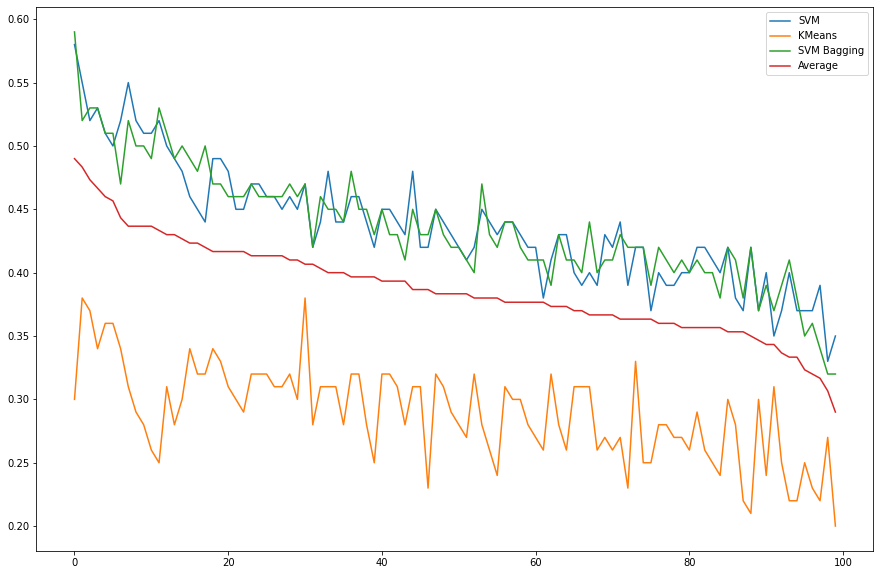

In [69]:
svc_accuracy = list()
kmc_accuracy = list()
bag_accuracy = list()

for i in range(100):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1)
    svc_accuracy.append(SupportVectorMachine(X_train, Y_train, 'poly', X_test, Y_test))
    kmc_accuracy.append(KMeansCluster(X_train, Y_train, 10, X_test, Y_test))
    bag_accuracy.append(BaggingClassification(X_train, Y_train, 'poly', X_test, Y_test))
   
average_accuracy = [ (kmc_accuracy[i] + svc_accuracy[i] + bag_accuracy[i])/3 for i in range(100)]

svc_accuracy = [ x for _, x in sorted(zip(average_accuracy, svc_accuracy), reverse=True) ]
kmc_accuracy = [ x for _, x in sorted(zip(average_accuracy, kmc_accuracy), reverse=True) ]
bag_accuracy = [ x for _, x in sorted(zip(average_accuracy, bag_accuracy), reverse=True) ]
average_accuracy = sorted(average_accuracy, reverse=True)

plt.figure(figsize=(15,10))

plt.plot(range(100), svc_accuracy, label='SVM') 
plt.plot(range(100), kmc_accuracy, label='KMeans')
plt.plot(range(100), bag_accuracy, label='SVM Bagging')
plt.plot(range(100), average_accuracy, label='Average')
plt.legend()

print(f"Average Accuracy: \nSVM: {round(np.mean(svc_accuracy)*100, 1)}%\nKMeans: {round(np.mean(kmc_accuracy)*100, 1)}%\nSVM Bagging: {round(np.mean(bag_accuracy)*100, 1)}%")

Hmm, seems like bagging performed only mildly better.

## Dimensionality Reduction

During the demo, Professor mentioned apprehensions regarding some of the features we were using, so here's a little bit of dimensionality reduction to see what actually matters:

PCA Accuracy: 0.45


<Figure size 1080x1440 with 0 Axes>

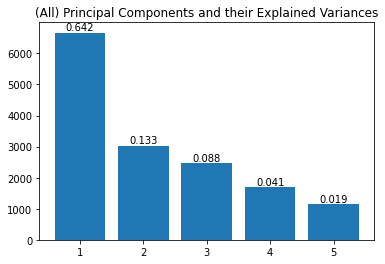

In [34]:
def dimensionalityReduction(X, Y, n_components=2, X_test=None, Y_test=None, predict=None, visual=False):
    '''
		Params		: 	Dataframe X, Dataframe Y, Integer n_components, Dataframe X_test, Dataframe Y_test, Boolean Predict, Boolean Visual
		Description	:	Uses principal component analysis to ease calculations by getting rid of redundant features 
		Return		: 	(void)
	'''
   
    pca = PCA(n_components=n_components)
    X_reduced = pca.fit_transform(X)

    if visual:
        singular_values = pca.singular_values_
        
        plt.figure(figsize=(15,20))
        fig, ax = plt.subplots()
        ax.bar(range(1, len(singular_values)+1), singular_values)
        
        ax.set_title("(All) Principal Components and their Explained Variances")
        
        rects = ax.patches
        
        for rect, label in zip(rects, pca.explained_variance_ratio_):
            height = rect.get_height()
            ax.text(
                rect.get_x() + rect.get_width()/2, height + 5, str(round(label, 3)), ha="center", va="bottom"
            )


    if X_test is not None and Y_test is not None:
        X_test_reduced = pca.transform(X_test)
        Y_test_pred = list()
        
        for X_t in X_test_reduced:
            prediction_similarity = [ cosine_similarity(X_t.reshape(1, -1), X_i.reshape(1, -1)) for X_i in X_reduced ]
            label_index = np.argmax(prediction_similarity)
            Y_test_pred.append(Y[label_index])
        
        return accuracy_score(Y_test, Y_test_pred)

    if predict is not None:
        X_predict_reduced = pca.transform(predict)
        
        for X_y in X_predict_reduced:
            prediction_similarity = [ cosine_similarity(X_y, X_i) for X_i in X_reduced ]
        
        return Y[np.argmax(prediction_similarity)]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1)

print(f"PCA Accuracy: {dimensionalityReduction(X_train, Y_train, n_components=5, X_test=X_test, Y_test=Y_test, visual=True)}")

The accuracy is comparable (mostly because we retained all 5 components - more on that below), even though we'd decided to discard PCA due to its inability to map temporal data (which is very present in music). But that doesn't seem like much of an issue since we're using mean spectral data in any case. 

Also seems like dimensionality reduction is very possible. Let's try doing the same thing but with reduced dimensions and see if that changes our accuracy.

PCA Accuracy (2-component): 0.27


<Figure size 1080x1440 with 0 Axes>

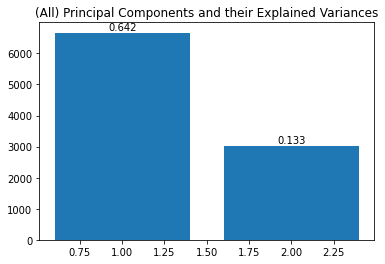

In [36]:
print(f"PCA Accuracy (2-component): {dimensionalityReduction(X_train, Y_train, n_components=2, X_test=X_test, Y_test=Y_test, visual=True)}")

Yikes! Our accuracy reduced to almost half. 

# Spotify Playlists

Okay but seriously, who cares about classifying some random audio tracks from 2001, some of us weren't even alive then. 

We will instead try and classify songs from **Spotify Playlists!**

To do this, we are leveraging two services (one legally, and the other a little sneakily). The first is the Spotify Developer's API, which we're accessing through a Python module called ```spotipy```. This gets us some housekeeping data about the entered playlist, which makes processing later on much easier. 

The second is a music streaming service called **Deezer**, which has a backdoor that piracy enthusiasts have been exploiting for years to download high fidelity music (though the company has slightly remedied the situation by shifting the lossless audio qualities to a separate subscription tier etc). A Python module called ```deemix``` takes care of utilizing the same Spotify Developer's API to convert an inputted Spotify playlist into a corresponding Deezer playlist, which then downloads. 

*Note:* We would recommend not running the next few code-blocks and directly importing the extracted features from the 5th code block below. The reasons for this is that the multiprocessing module was being problematic on Windows, and the deemix module was being problematic on Linux environments. We only worked around it by constantly switching between Windows/WSL/Dual-Boot. If you do want to go ahead anyway, the spotipy module will work out of the box if the spotifyCredentials file is in the same directory, but you will need to configure the Spotify credentials on deemix manually. Navigate to Lib\site-packages\deemix\plugins\spotify.py, and in the __init__ function of the Spotify class, add the clientId and clientSecret to the self.credentials dictionary as strings. 

The module will prompt for a Deezer arl if you try to use it. This we cannot provide for you since it's browser unique in our experience, but creating a free Deezer account using an US VPN will suffice. You will find your arl key in Developer Tools > Storage > Cookies.


In [38]:

# DO NOT EXECUTE at the top of the four codeblocks that are right after it

with open('spotifyCredentials', mode='r') as f:
    credentials = f.readlines()
    credentials = {'id': credentials[0].strip(), 'secret': credentials[1].strip()}
    
spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(client_id=credentials['id'], client_secret=credentials['secret']))

We get information about the playlist, and then parse the information in it to generate the filenames that ```deemix``` will use later on to import. The code below does this parsing and prints out the filenames of some songs.

In [45]:
import json

playlistUrl = input()

playlist_items = spotify.playlist_items(playlistUrl)

with open('playlist_items.json', 'w') as f:
    json.dump(playlist_items, f)

songs = list()

for i, song in enumerate(playlist_items['items']):
    songs.append({'name': song['track']['name'], 'artist': song['track']['artists'][0]['name'], 'album': song['track']['album']['name'], 'url': song['track']['external_urls']['spotify']})
    songs[i]['filename'] = f"{str(i+1).zfill(2)} - {songs[i]['artist']} - {songs[i]['name']}.mp3"
    print(songs[i]['filename'])
    
with open('song_data.json', 'w') as f:
    json.dump(songs, f)

01 - Lisa Hannigan - Lille.mp3
02 - RANJ - Come Thru.mp3
03 - Simon & Garfunkel - April Come She Will.mp3
04 - City and Colour - Northern Wind.mp3
05 - Passenger - Staring at the Stars.mp3
06 - Passenger - Rosie.mp3
07 - Fleet Foxes - Featherweight - Acoustic Version.mp3
08 - The Staves - Mexico.mp3
09 - John Denver - Annie's Song.mp3
10 - Paul McCartney - Calico Skies.mp3
11 - The Velvet Underground - After Hours.mp3
12 - Tai Verdes - momma told me imma be.mp3
13 - Vampire Weekend - Step.mp3
14 - Kansas - Dust in the Wind.mp3
15 - Tom Petty - Wildflowers.mp3
16 - Zack Tabudlo - Binibini.mp3
17 - Don McLean - Vincent.mp3
18 - Billy Joel - Vienna.mp3
19 - Yusuf / Cat Stevens - The Wind.mp3
20 - The Magnetic Fields - The Book of Love.mp3
21 - The Monkees - Me & Magdalena.mp3
22 - The Beatles - Blackbird - Remastered 2009.mp3
23 - Simon & Garfunkel - Blues Run the Game - Studio Outtake - 1965.mp3
24 - The Beatles - I'll Follow The Sun - Remastered 2009.mp3
25 - James Taylor - You Can Clos

The snippet below utilizes ```deemix``` to download a playlist. This won't work without a VPN. If you use a VPN, it will ask you for an ```arl``` string, which you must get by logging into Deezer (using a VPN), and then using your browser developer tools, navigate to the stored cookies, and find the one called ```arl```.

In [ ]:
from deemix import __main__ as dm
import os

dm.download([playlistUrl], 'FLAC', "True", [str(os.getcwd())])

The code below iterates through each downloaded song, extracts features from them and then feeds those predictions to the classifiers to give scores. 

In [ ]:
with open('song_data.json', 'r') as f:
    songs = json.load(f)

ROOT_DIR = r'C:\Users\soham\Music\deemix Music'
ROOT_DIR = r'/mnt/c/Users/soham/Music/deemix Music'

song_paths = list()

song_fnames = [ song['filename'].lower().replace('?', '_').replace('!', '_') for song in songs ]


for dirpath, dirnames, filenames in os.walk(ROOT_DIR):
    for files in filenames:
        if files.lower() in song_fnames:
            song_index = song_fnames.index(files.lower())
            song_paths.append(os.path.join(dirpath, files))


songFeatures = list()

with Pool(None) as p:
    songFeatures = p.map(processSong, song_paths) # more concurrency

songFeatures_df = pd.DataFrame(songFeatures).to_csv('songFeatures.csv', index=False, header=False)

In [57]:
# EXECUTE FROM HERE at the top of this one

songFeatures = pd.read_csv('songFeatures.csv', header=None, index_col=False).to_numpy()

kmc_predictions__ = KMeansCluster(X, Y, 10, predict=songFeatures)
svc_predictions__ = SupportVectorMachine(X, Y, 'poly', predict=songFeatures)
bag_predictions__ = BaggingClassification(X, Y, kernel='poly', predict=songFeatures)

kmc_taste = [ music_indices[x] for x in kmc_predictions__ ]
svc_taste = [ music_indices[x] for x in svc_predictions__ ]
bag_taste = [ music_indices[x] for x in bag_predictions__ ]

def getFreqRatio(freqDistr):
    return {k: f"{round(v/sum(freqDistr.values())*100, 1)}%" for k, v in freqDistr.items()}

kmc_distr = getFreqRatio(Counter(kmc_taste))
svc_distr = getFreqRatio(Counter(svc_taste))
bag_distr = getFreqRatio(Counter(bag_taste))

print(tabulate.tabulate({
    "KMC": kmc_distr.keys(),
    "KMC Genre Distribution": kmc_distr.values(),
    "SVC": svc_distr.keys(),
    "SVC Genre Distribution": svc_distr.values(),
    "Baging": bag_distr.keys(),
    "Bagging Genre Distribution": bag_distr.values()
}, headers='keys'))


KMC        KMC Genre Distribution    SVC      SVC Genre Distribution    Baging    Bagging Genre Distribution
---------  ------------------------  -------  ------------------------  --------  ----------------------------
jazz       65.4%                     jazz     15.4%                     jazz      15.4%
pop        11.5%                     reggae   7.7%                      reggae    7.7%
disco      7.7%                      blues    15.4%                     blues     19.2%
rock       11.5%                     rock     34.6%                     country   19.2%
classical  3.8%                      pop      15.4%                     pop       11.5%
                                     country  11.5%                     rock      26.9%


We can see that each of the algorithms actually performed quite differently on the same real world data. KMC and SVC are both quite biased, the former towards jazz and the latter towards rock. Bagging seems to have donated some of SVC's rock songs to country and blues. We'll see exactly what happened in a second.

Here is the genre as stored by Deezer as loaded from the MP3 file tags. While labelling provided by a single entity can potentially be misleading, these labels have been decided either by the writers/composers/performers of the songs themselves, or by other experts in the field. True, it can be prone to biases, but these people are also the most likely to have objective reasons for choosing the labels they've chosen. We will use these labels to see how our models have performed.

In [ ]:
mp3_genre = list()
song_name = list()

for song in song_paths:
    song_metadata = eyed3.load(song)
    song_genre = song_metadata.tag.genre
    mp3_genre.append(song_genre.name)
    song_name.append(song_metadata.tag.title)

with open('final_taste_predictions.json', 'w') as f:
    json.dump({'name': song_name, 'kmc': kmc_taste, 'svc': svc_taste, 'bag': bag_taste, 'service': mp3_genre}, f)

You won't be able to use deemix on campus, so use the snippet below to import some data that I used for testing. 

```tastes``` is a dictionary containing multiple arrays, song titles and genre predictions by KMC, SVM and Bagged-SVM

```songs``` contains the limited metadata (song name, artist, album, filename)

```playlist_items``` is the entire response from the Spotify API service. 

In [28]:
with open('final_taste_predictions.json', 'r') as f:
    tastes = json.load(f)

with open('selective_metadata.json', 'r') as f:
    songs = json.load(f)

with open('playlist_items.json', 'r') as f:
    playlist_items = json.load(f)

with open('song_paths.json', 'r') as f:
    song_paths = json.load(f)

Below, you'll find a code-generated table containing all the different genres of the song - predictions and truths. 

KMC has a high bias for Jazz. We're not sure if it's a true bias due to the training data, or if it's due to the cluster-to-label mapping that we did statistically. We know the latter is a hacky-fix which makes the entire KMC prediction set highly unreliable.

SVC and Bagging both performed fairly similarly, which isn't surprising since the latter employs the former and yielded similar accuracies (which we also plotted on the graph right at the top).

### What you will see: 

... is that most of the genres don't match the labels done by the service. Now, that could be due to the low (ish) accuracies of the models themselves (SVM's ~55% isn't super reliable), but we think there might be more to it.

Music is an evolving art form. The GTZAN dataset was created in the early 2000s, and must have been comprising of mostly audio tracks from the 1990s (if not earlier). Sure, it might have been an effortful endeavour, and a respectable collection, but that was *back then*. 

**Today's music isn't what it used to be 20 years ago.** Not only do the genres represent vastly different kinds of music today than they used to, but today's music toes the line between multiple different genres so much more. It's not out-of-place to find a track that embodies jazz, pop, and country elements all at once. 

Some of these predictions below might be genuine misclassifications, sure. But if you take a moment to listen to some of the tracks in the [GTZAN dataset](http://marsyas.info/downloads/datasets.html), and some of the tracks that we got from [my friend's playlist](https://open.spotify.com/playlist/5TQE3gRTNgNHwEfosV5EyQ?si=68214d874094438b), you'll find that a song like **Come Thru** by **RANJ, Clifr and Issamood**, while being primarily Hip-Hop, also contains the Carribbean rhythm of a reggae song. Others like **Wildflowers** by **Tom Petty** might not be *disco* (as predicted by Bagging), but the raw guitar and vocals can easily be recognized as some of the softer sub-genres of rock music. 

And then there's **Ocean** by **Anuv Jain** - it's literally just a guitar strumming along to some vocals about finding peace. No offence to him, but I think Anuv might've chosen rock when filling out the song-publishing form to sound cooler to his friends - *"Hey, I'm a rockstar now!"*

In [32]:
genreClassification = pd.DataFrame({'Song': tastes['name'], 'KMC': tastes['kmc'], 'SVC': tastes['svc'], 'Bagging (SVC)': tastes['bag'], 'Service': tastes['service']})

print(tabulate.tabulate(genreClassification, headers='keys'))  


    Song                                KMC        SVC      Bagging (SVC)    Service
--  ----------------------------------  ---------  -------  ---------------  -----------------------------
 0  Lille                               jazz       jazz     jazz             Pop
 1  Come Thru                           pop        reggae   reggae           Rap/Hip Hop/Pop
 2  April Come She Will                 jazz       blues    blues            Pop
 3  Northern Wind                       jazz       rock     country          Alternative/Rock
 4  Staring at the Stars                disco      pop      pop              Pop
 5  Rosie                               jazz       blues    blues            Rock/Singer & Songwriter
 6  Mexico                              jazz       jazz     jazz             Alternative
 7  Annie's Song                        jazz       rock     rock             Pop
 8  Calico Skies                        jazz       rock     rock             Pop/Rock
 9  After Hours     

## GTZAN as a Dataset

We don't mean to hate the GTZAN Dataset, this project would not have been possible without it. But it hasn't aged well, and that's not GTZAN's fault. Tzanetakis could not have known that artists today would be so creatively deviant. Additionally, the audio quality of the GTZAN tracks are also not the best - lots of audio fragments and noise: *"Unfortunately the database was collected gradually and very early on in my research so I have no titles (and obviously no copyright permission etc). The files were collected in 2000-2001 from a variety of sources including personal CDs, radio, microphone recordings, in order to represent a variety of recording conditions."*

### The answer to GTZAN as a Dataset? (Future Work)

There are other datasets that could be experimented with for this project itself. This includes the [Real World Computing Music Database](https://staff.aist.go.jp/m.goto/RWC-MDB/) and the [CAL500 Dataset](http://calab1.ucsd.edu/~datasets/). It would be interesting to compare the performances of the same models used above across these datasets, although there will have to be significant changes to our feature sets (since CAL500 does not provide audio tracks at all, just extracted numerical data). 

After a thorough comparison and evaluation of these datasets against modern music, it might be worthwhile to use them as a baseline to create a new, modern dataset. The rough pipeline that we've envisioned for such a task is as follows:
1. For each of the genres above, create a list of 50-100 songs from the past five (or ten) years **each**. 
2. Split each song into multiple sections of equal length. This can be a simple time-based segmentation (0-30s, 30-60s, 60-90s and so on), **OR**, Spotify has a very nifty [Audio Analysis API Endpoint](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-analysis) which produces qualitative segmentation of a song into sections, bars, beats, segments, and tatums (each getting progressively smaller - a section consists of bars, a bar consists of beats and so on). This could potentially be exploited to extract the **_jazziest_** part of a jazz song for example. 
3. Classify each segment, and obtain a confidence measure for the top n genres. Ideally, each segment should have the same classification, but with varying confidences. 
4. Retain the segment with the highest confidence for the correct genre as a candidate for the dataset, say goodbye to the rest. 

Of course, this dataset would also be prone to the same issue of becoming out-of-date. But perhaps the process above can be used continually, training and re-training on new music, itself evolving as continually as the art form it tries to represent. 

## Our project as a product

But we will not be so quick to abandon the results of our work. Here are some pictorial representations of your taste in music. 

Text(0.5, 1.0, 'Bagging')

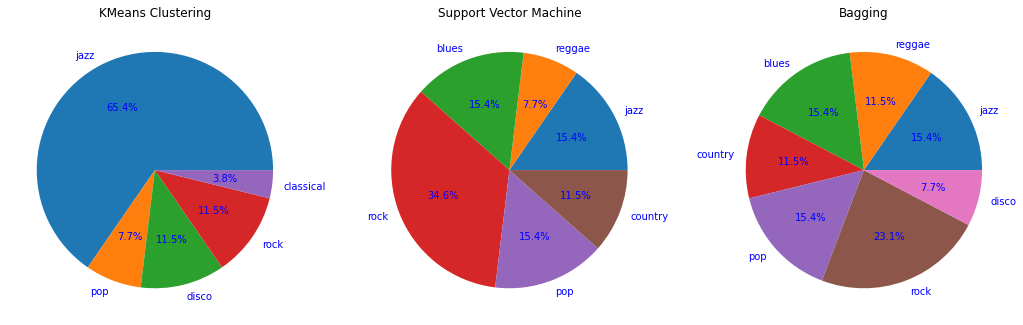

In [39]:
# svc chart 
svc_data = Counter(tastes['svc'])
svc_labels = Counter(tastes['svc']).keys()

kmc_data = Counter(tastes['kmc'])
kmc_labels = Counter(tastes['kmc']).keys()

bag_data = Counter(tastes['bag'])
bag_labels = Counter(tastes['bag']).keys()


fig = plt.figure(figsize=(18, 10))

kmc_pie = plt.subplot2grid((1, 3), (0, 0))
plt.pie([float(v) for v in kmc_data.values()], labels = kmc_labels, autopct= '%1.1f%%', textprops={'color':"b"})
plt.title('KMeans Clustering')

svc_pie = plt.subplot2grid((1, 3), (0, 1))
plt.pie([float(v) for v in svc_data.values()], labels = svc_labels, autopct= '%1.1f%%', textprops={'color':"b"})
plt.title('Support Vector Machine')

bag_pie = plt.subplot2grid((1, 3), (0, 2))
plt.pie([float(v) for v in bag_data.values()], labels = bag_labels, autopct= '%1.1f%%', textprops={'color':"b"})
plt.title('Bagging')


## A Quick Note on Music Generation

Our pipeline wanted to include personalized music generation as a potential use-case for waveform based classification. Simply put, if digital amplitudes could be interpreted to contribute to the kind of music it is, encapsulating musical elements like rhythm, harmony, etc, then it could potentially be used to generate new music as well. 

We wanted to use a Generative Adversarial Network for this purpose, where the generated tracks would continually be evaluated by the models we've presented above. However, the truth is that music generation is still at a stage where it requires MIDI data to get answers to the following questions:
1. What notes are in this? 
2. How frequently is that note occurring? 
3. What instrument is that note coming from? 

Fourier Transforms of the waveforms can potentially answer the first question, and with some difficulty maybe the second, but qualitative attributes from the third would be close to impossible. 

### Why not just use MIDI files?

MIDI Files are difficult. Most of the music we hear today is still recorded, so creating a MIDI file of that would be extra manual labour. Doing it by ear would be a difficult and lengthy task for even a highly trained expert with a good ear and proficiency with multiple instruments, and it's not like the music publishing giants of the world would freely distribute copyrighted sheet music for others to replicate. It would come at a steep price. And existing MIDI files of music in the public domain wouldn't contribute to our pipeline - all we'd be able to work with are classical music pieces from the mid-20th century. 

We did try out [GANSynth](https://magenta.tensorflow.org/gansynth) by Tensorflow. It's not exactly what we wanted to do, it's trained on the [NSynth Dataset](https://magenta.tensorflow.org/datasets/nsynth) to recognize how different musical notes from different instruments might interact well with each other, and uses that information to modify the timbre of an existing piece of MIDI music. 

We tried it out with a short segment of a contemporary song, it produced an interesting result. We've included it in the zip file as ```turning_tables.wav```